In [1]:
!pip install prophet -q

In [5]:
from prophet import Prophet
import pandas as pd 
df = pd.read_excel('data4.xlsx',sheet_name='AFG')
df.head()

,Date,Population,BCG_demand
0,1980-01-01,4718.013,0.00000
1,1981-01-01,4220.864,0.00000
2,1982-01-01,3818.601,381.86010
3,1983-01-01,3766.472,376.64720
4,1984-01-01,3874.202,426.16222


In [15]:
#df = df.drop('Population', axis=1)
df = df.rename(columns = {'Date':'ds', 'BCG_demand':'y'})

In [16]:
df.head()

,ds,y
0,1980-01-01,0.00000
1,1981-01-01,0.00000
2,1982-01-01,381.86010
3,1983-01-01,376.64720
4,1984-01-01,426.16222


In [17]:
m = Prophet()
m.fit(df)

10:24:41 - cmdstanpy - INFO - Chain [1] start processing
10:24:43 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
periods = 10
future = m.make_future_dataframe(periods, freq='A', include_history=True)
future.tail()

,ds
47,2026-12-31
48,2027-12-31
49,2028-12-31
50,2029-12-31
51,2030-12-31


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
42,2021-12-31,12047.851400,11504.346174,12560.911359
43,2022-12-31,12697.769623,12166.204415,13214.105620
44,2023-12-31,13408.569629,12871.889799,13971.978141
45,2024-12-31,12963.142769,12446.443298,13529.410238
46,2025-12-31,13551.729230,13014.804855,14080.203446
47,2026-12-31,14201.647453,13698.426430,14774.211328
48,2027-12-31,14912.447459,14365.210743,15501.811693
49,2028-12-31,14467.020599,13894.678589,15006.617509
50,2029-12-31,15055.607060,14503.812491,15654.875689
51,2030-12-31,15705.525282,15149.953526,16298.893333


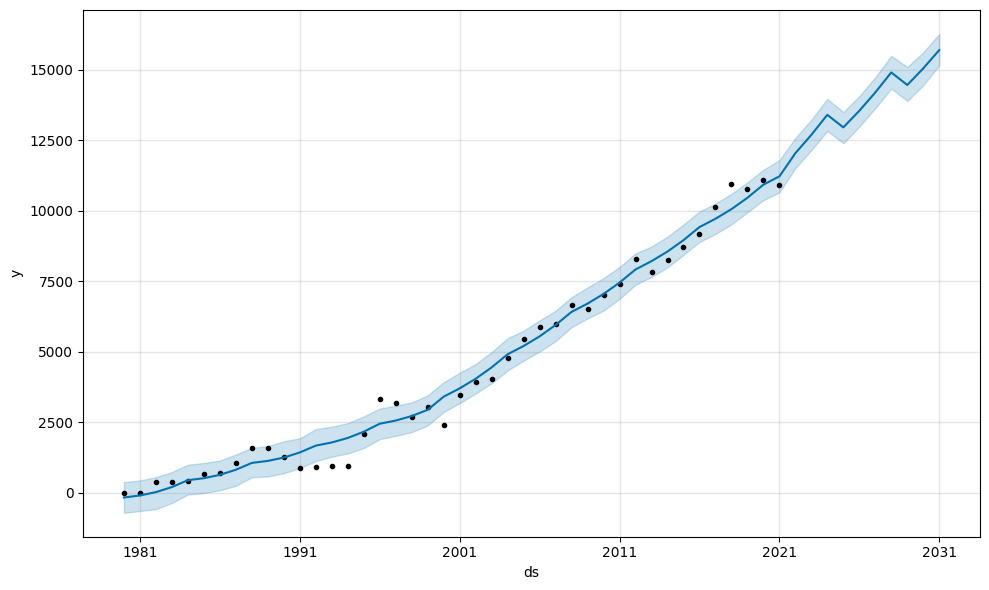

In [21]:
fig1 = m.plot(forecast)


In [2]:
import pandas as pd 
df_var = pd.read_excel('data4.xlsx',sheet_name='AFG')

In [3]:
df_var.head()

,Date,Population,BCG_demand
0,1982-01-01,3818.601,381.86010
1,1983-01-01,3766.472,376.64720
2,1984-01-01,3874.202,426.16222
3,1985-01-01,3973.340,675.46780
4,1986-01-01,3962.922,713.32596


In [4]:
df_var['Date'] = pd.to_datetime(df_var.Date , format = '%d/%m/%Y')
data = df_var.drop(['Date'], axis=1)
data.index = df_var.Date
#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
       if data[j][i] == -200:
           data[j][i] = data[j][i-1]

#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = data
coint_johansen(johan_test_temp,-1,1).eig

array([0.21400565, 0.00144174])

In [5]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=90)

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [20]:
#converting predictions to dataframe
from sklearn.metrics import mean_squared_error
import numpy as np 
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,2):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(new[0:8], valid[i])))

rmse value for Population is :  727.7004055827894
rmse value for BCG_demand is :  1648.353748926192


In [16]:
new = pred[i]

In [19]:
new[0:8]


,Population
0,11000.289793
1,11134.430887
2,11268.096208
3,11400.954267
4,11532.72384
5,11663.167552
6,11792.086264
7,11919.314145


In [41]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.endog, steps=10)
df_pred = pd.DataFrame(yhat, columns = ['Population_pred','BCG_demand_pred'])
year = ['2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01','2027-01-01','2028-01-01','2029-01-01','2030-01-01','2031-01-01']
df_pred['Date'] = year
df_pred['Date'] = pd.to_datetime(df_pred.Date , format = '%Y/%m/%d')
df_pred.head()



/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


,Population_pred,BCG_demand_pred,Date
0,13192.903298,11185.305047,2022-01-01
1,13403.399302,11465.892553,2023-01-01
2,13612.551222,11745.713454,2024-01-01
3,13820.320122,12024.607478,2025-01-01
4,14026.672336,12302.431958,2026-01-01


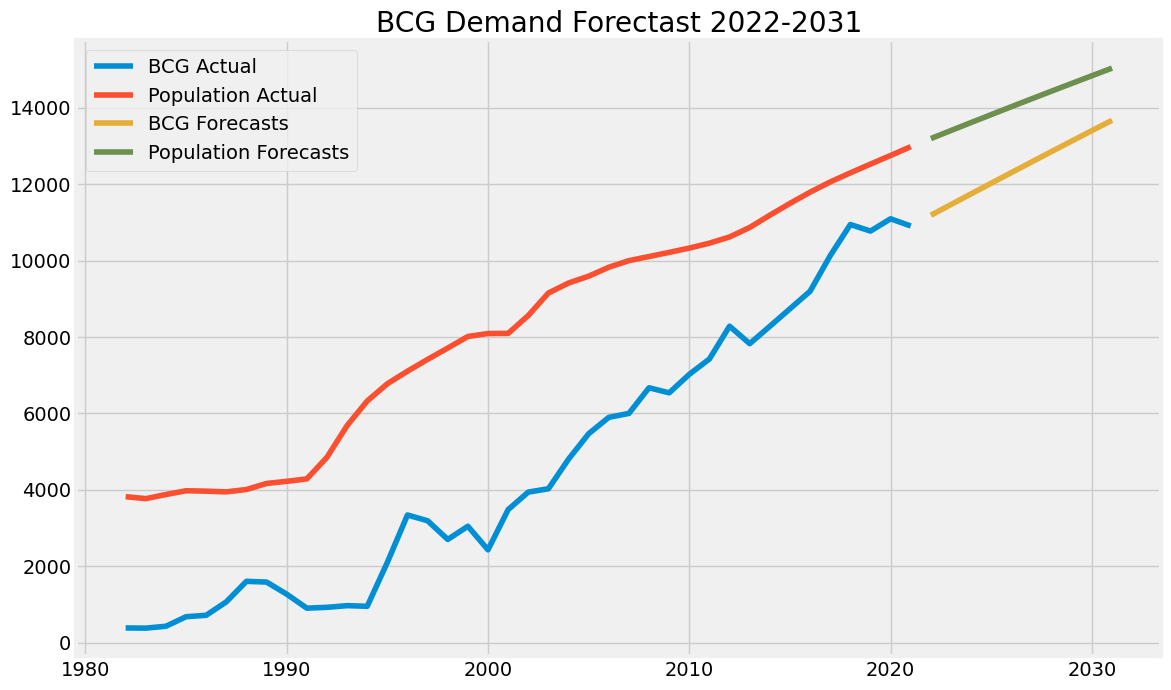

In [47]:
plt.figure(figsize=(14, 8))
plt.style.use('fivethirtyeight')
# Plotting the Actuals
plt.plot(df_var.Date, df_var.BCG_demand, label='BCG Actual')
plt.plot(df_var.Date, df_var.Population, label='Population Actual')
# Plotting the Forecasts
plt.plot(df_pred.Date, df_pred.BCG_demand_pred, label='BCG Forecasts')
plt.plot(df_pred.Date, df_pred.Population_pred, label='Population Forecasts')
plt.legend(loc='best')
plt.title("BCG Demand Forectast 2022-2031")
plt.show()